## Data Preparation

In [2]:
from typing import Optional
from dataclasses import dataclass
import pickle
from datetime import datetime as dt
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
import os

### Necesarry Helper Functions

In [3]:
@dataclass
class Form:
    # Same for both sources
    filing_date: str
    trade_date: str
    ticker: str
    price: float
    qty_bought: float
    qty_owned: float

    #Source: openinsider.com
    insider_name_link: Optional[str] = None 
    company_link: Optional[str] = None
    buyer_title: Optional[str] = None
    
    #Source: SEC Bulk Data
    accession_number: Optional[str] = None
    insider_name: Optional[str] = None 
    company_name: Optional[str] = None
    insider_relationship: Optional[str] = None 
    insider_title: Optional[str] = None 
    fd_index: Optional[int] = None

    def __eq__(self, other) -> bool:
        return self.filing_date == other.filing_date and self.trade_date == other.trade_date and self.ticker == other.ticker and self.price == other.price and self.qty_bought == other.qty_bought and self.qty_owned == self.qty_owned
    
    def __ne__(self, other) -> bool:
        return not self.__eq__(other)
    
    def delta_own(self):
        if self.qty_owned is None or self.qty_bought is None: raise ValueError("Class values were None")

        if self.qty_owned - self.qty_bought == 0:
            return 100
        else:
            return float(self.qty_bought / (self.qty_owned - self.qty_bought)) * 100

    def days_ago(self) -> int:
        if self.filing_date is None or self.trade_date is None:
            raise ValueError("Class values were None")
        fd = dt.strptime(self.filing_date, "%Y-%m-%d")
        td = dt.strptime(self.trade_date,  "%Y-%m-%d")
        return (fd - td).days
  
def save_data(data, fname):
    """
    base path is Assets folder
    """
    with open(f"Assets/{fname}.pkl", "wb") as file:
        pickle.dump(data, file)

def load_data(fname) -> list:
    with open(f"Assets/{fname}.pkl", "rb") as file:
        data = pickle.load(file)
        return data

def tickers_from_data(forms: list[Form]):
    tickers = {}
    for form in forms:
        tickers[form.ticker] = 1

    return [key for key in tickers.keys()]

@dataclass
class Candle:
    date: str
    o: float
    c: float
    h: float
    l: float
    v: int

@dataclass(repr=False)
class Trade:
    form: Form
    candles: list[Candle]
    onem_profit: Optional[float] = None
    twom_profit: Optional[float] = None
    threem_profit: Optional[float] = None

    def __repr__(self) -> str:
        return f"{self.form.insider_name} ({self.form.insider_relationship}): {self.form.qty_bought} {self.form.ticker} @ {self.form.price} on {self.form.filing_date} ({self.form.accession_number})"

    def catalyst_size(self, shift):
        """
        NOTE: candles[0] needs to be at the filing date, and candles[-1] should be the final day\n
        @param n_days is how many days after the filing date the calculations should consider\n
        @param shift is how many days each peak should be shifted to the right by
        """
        avg_peak_val: float = 0.0

        closes = [c.c for c in self.candles]
        _, peaks = get_peaks(closes, shift)
        
        if len(peaks) != 0:
            for peak in peaks:
                avg_peak_val += self.candles[peak].c
                # print(f"{self.candles[peak].c}, {peak}")
            avg_peak_val /= len(peaks)
            # print(f"AVG PEAK: {avg_peak_val}")
            # print(f"First Close: {self.candles[0].c}")
            return pct_change(self.candles[0].c, avg_peak_val)
        
        # if there are no peaks (sad face), return absolute change
        return pct_change(closes[0], closes[-1])
    
    def returns(self, days: int, candles: list[Candle] = []) -> float:
        """
        Percent return over (@param days) number of days from close to close\n
        Negative days shows past returns up to the filing date\n
        Used to check the passivity of a certain transaction\n
        """
        if days > 0:
            if len(self.candles) > days:
                return pct_change(self.candles[0].c, self.candles[days - 1].c)
            
        data = []
        if len(candles) == 0:
            data = get_ticker_data(self.form.ticker)
            assert data is not None
        else: 
            data = candles

        fdi = self.form.fd_index
        assert fdi is not None
    
        if days < 0:
            data = trim_ticker_data(data, fdi, (-days, 1))
        elif days > 0:
            data = trim_ticker_data(data, fdi, (0, days))
        else: return 0

        return pct_change(data[0].c, data[-1].c)
    
def moving_avg(data: list, length: int):
    new_data = []
    window = []
    for d in data:
        if len(window) <= length:
            window.append(d)
        else:
            window = window[1:]
            window.append(d)

        new_data.append(sum(window)/len(window))
    return new_data

def pct_change(from_, to_):
    return ((to_ - from_) / from_) * 100

def get_peaks(price_data: list, shift: int):
    """
    @param price_data: list of prices (typically the closing prices)\n
    @param shift: move each peak to the right n-days because seldom will you exit at the true peak of a stock\n
    """
    ma = moving_avg(price_data, 7)

    dist = 7
    height_multiplier = 1.05
    peaks, _ = find_peaks(ma, distance=dist, height=ma[0] * height_multiplier, width=5) # one week between peaks and peak must be a 5% increase from day 0


    while len(peaks) == 0 and dist >= 1:
        peaks, _ = find_peaks(ma, distance=dist, width=5) # one week between peaks and peak must be a 5% increase from day 0
        dist -= 1

    if pct_change(ma[0], ma[-1]) > 5:
        peaks = list(peaks)

        s = 0.0
        for p in peaks:
            s += ma[p]

        avg_peak_height = s/len(peaks)
        if ma[-2] > avg_peak_height:
            peaks.append(len(ma) - 2) # add second index from the end

    if len(peaks) == 0: return [], []

    for i in range(len(peaks)):
        if i < len(peaks) - 1:
            peaks[i] += shift 

    return ma, peaks

def show_trade(trade: Trade, show_peaks: bool):
    prices = pd.DataFrame({
        "high"  : [candle.h  for candle in trade.candles],
        "low"   : [candle.l  for candle in trade.candles],
        "open"  : [candle.o  for candle in trade.candles],
        "close" : [candle.c  for candle in trade.candles]
    })
    green  = prices[prices.close >= prices.open] # green candles
    red    = prices[prices.close < prices.open] # red candles
    w1, w2 = 0.4, 0.02 # width of thick part and width of extrema

    _, ax = plt.subplots()
    # graph green candles (x, height, width, bottom, color)
    ax.bar(green.index, green.close - green.open, w1, green.open, color='green') # thick middle part
    ax.bar(green.index, green.high  - green.close, w2, green.close, color='black') # high price
    ax.bar(green.index, green.low  - green.open, w2, green.open, color='black') # low price
    
    ax.bar(red.index, red.close - red.open, w1, red.open, color='red') # thick middle part
    ax.bar(red.index, red.high  - red.open, w2, red.open, color='black') # high price
    ax.bar(red.index, red.low   - red.close, w2, red.close, color='black') # low price

    if show_peaks:
        ma, peaks = get_peaks(list(prices.close.array), 3)
        ax.plot(ma)
        
        for peak in peaks:
            ax.plot(peak, list(prices.close.array)[peak], "bo")


    title = f"{trade.form.ticker} @ {trade.candles[0].date} (FD: {trade.form.filing_date}, TD: {trade.form.trade_date})"

    ax.set_title(title)
    plt.show()

def get_ticker_data(ticker: str):
    """
    open and return the data associated with a certain ticker\n
    returns None is no data are found
    """
    contents = os.listdir(f"Assets/Historical_Stock_Data")
    if f"{ticker}.pkl" not in contents: return None
    else: return load_data(f"Historical_Stock_Data/{ticker}")

def trim_ticker_data(data: list[Candle], fd_index: int, window: tuple[int, int]):
    """
    @param window is a tuple of how many candles should be included before and after the filing date\n
    \t --> i.e. (10, 100) means to show from 10 days before to 100 days after
    """
    start = fd_index - window[0] if fd_index - window[0] >= 0 else 0
    end = fd_index + window[1] if fd_index + window[1] < len(data) else len(data) - 1
    data = data[start : end]
    return data

def trade_from_histform(form: Form, n_days):
    """
    returns trade object with candles from fd up to (fd + n_days)
    """
    data = get_ticker_data(form.ticker)
    if data is None: return

    i = form.fd_index
    if i is None: 
        print("❌FDI NOT FOUND")
        return

    data = data[i:i + n_days]

    trade = Trade(
        form,
        data
    )

    return trade

def show_hist_trade(form: Form, n_days: int, show_peaks: bool):
    if form.ticker is None: return
    if form.filing_date is None: return

    data = get_ticker_data(form.ticker)
    if data is None: return

    i = form.fd_index
    if i is None: 
        print("❌FDI NOT FOUND")
        return

    data = data[i : i + n_days]

    trade = Trade(
        form,
        data
    )

    show_trade(trade, show_peaks)

    return trade

### Load in Data

In [4]:
forms: list[Form] = load_data("HistForms")

In [6]:
l = len(forms)
trades: list[Trade] = []
for i, form in enumerate(forms):
    print(f"{i/(l - 1)*100:.2f}%", end='\r')
    t = trade_from_histform(form, 100)
    if t is not None: # * this line ensures each trade has data!
        trades.append(t)

trades = list(filter(lambda x: len(x.candles) > 0 and x.candles is not None, trades)) # filter such that...

In [6]:
trades: list[Trade] = load_data("Trades")

### Ensure Successful Loading

In [ ]:
trade = show_hist_trade(trades[10].form, 100, False) # set result to a variable so it doesn't print it out

In [ ]:
trades[10].returns(30)

In [ ]:
trades[10].returns(60)

In [ ]:
trades[10].returns(90)

### Track the Insider and Company in Question

In [4]:
def get_insider_and_company_dict(trades: list[Trade]) -> tuple[dict[str, list[Trade]], dict[str, list[Trade]]]:
    # get dictionary of "insider name" : [forms...]
    insider_dict: dict[str, list[Trade]] = {}
    # get dictionary of "ticker" : [forms...]
    company_dict: dict[str, list[Trade]] = {}

    for trade in trades:
        iname = trade.form.insider_name
        if iname is None: continue
        if iname not in insider_dict:
            insider_dict[iname] = [trade]
        else:
            insider_dict[iname].append(trade)

        cname = trade.form.ticker
        if cname is None: continue
        if cname not in company_dict:
            company_dict[cname] = [trade]
        else:
            company_dict[cname].append(trade)
        
    return insider_dict, company_dict

In [5]:
def get_cluster_score(curr: Trade, company_trades: list[Trade]):
    cd = dt.strptime(curr.form.trade_date, "%Y-%m-%d")

    cluster_score = 0

    # filter such that every trade in the comapnies history is from before the current trades filing date
    for t in list(filter(lambda x: dt.strptime(x.form.trade_date, "%Y-%m-%d") <= cd and x.form.accession_number != curr.form.accession_number, company_trades)):
        td = dt.strptime(t.form.trade_date, "%Y-%m-%d")
        if (cd - td).days < 30:
            cluster_score += 1
    
    return cluster_score

### Map Insider Job Title to Numbers

- Other = 1
- 10% owners = 2
- Director = 3
- Officer = 4
- Vice President (EVP or SVP) = 5
- President = 6

In [7]:
def map_insider_title(r: str) -> int:
    r = r.lower()

    if "other" in r:
        return 1

    if "tenpercentowner" in r:
        return 2
    
    if "director" in r:
        return 3
    
    if "officer" in r:
        t = f.insider_title
        assert t is not None
        t = t.lower()

        if "vice president" in t or "svp" in t or "evp" in t:
            # must be before the check for president
            return 5
        
        if "president" in t:
            return 6
        
        return 4

    #* tested on all forms and never reached
    return 0

## Conduct Analysis

In [1]:
import pandas as pd

#### Import data into a pandas dataframe
First it needs to be created and then saved to csv, where it can then be read in from said file (much quicker)

In [35]:
i_dict, c_dict = get_insider_and_company_dict(trades)

data = {
    "ticker": [],
    "insider_name": [],
    "qty_bought": [],
    "qty_owned": [],
    "share_price": [],
    "owner_title": [],
    "days_ago": [],
    "delta_own": [],
    "filing_date": [],
    "trade_date": [],
    "cluster_score": [],
    "returns(90)": [],
}

l = len(trades)
for i, t in enumerate(trades):
    print(f"{i / (l-1) * 100 :.2f}%", end='\r')
    f = t.form
    data["ticker"].append(f.ticker)
    data["insider_name"].append(f.insider_name)
    data["qty_bought"].append(f.qty_bought)
    data["qty_owned"].append(f.qty_owned)
    data["share_price"].append(f.price)
    data["owner_title"].append(f.insider_relationship)
    data["days_ago"].append(f.days_ago())
    data["delta_own"].append(f.delta_own())
    data["filing_date"].append(f.filing_date)
    data["trade_date"].append(f.trade_date)
    data["cluster_score"].append(get_cluster_score(t, c_dict[f.ticker]))
    data["returns(90)"].append(t.returns(90))

df = pd.DataFrame.from_dict(data)

In [9]:
df = pd.read_csv("Assets/DataFrame.csv")

In [10]:
df.drop("Unnamed: 0", axis=1, inplace=True) # remove weird column that was the row number
df.head()

,ticker,insider_name,qty_bought,qty_owned,share_price,owner_title,days_ago,delta_own,filing_date,trade_date,cluster_score,returns(90)
0,CQP,Blackstone Holdings I/II GP L.L.C.,27258.00,2277677.0,33.71,TenPercentOwner,1,1.211241,2020-12-31,2020-12-30,1,15.914894
1,CQP,BIP Chinook Holdco L.L.C.,27258.00,2277677.0,33.71,TenPercentOwner,1,1.211241,2020-12-31,2020-12-30,1,15.914894
2,SOBR,Graham Gary John,3103028.00,15103028.0,1551514.00,TenPercentOwner,24,25.858567,2020-12-31,2020-12-07,0,-1.694896
3,USIO,"Topline Capital Management, LLC",100000.00,3475000.0,1.32,Other,1,2.962963,2020-12-31,2020-12-30,5,103.370787
4,AIRT,KOHLER GARY S,38124.54,2000.0,19.06,Director,2,-105.536403,2020-12-31,2020-12-29,0,-13.702008


#### Comb Through Data
Find oddities in the statistics and investigate their accuracy

In [44]:
df.describe()

,qty_bought,qty_owned,share_price,days_ago,delta_own,cluster_score,returns(90)
count,3.766900e+04,3.766900e+04,3.766900e+04,37669.000000,3.766900e+04,37669.000000,37669.000000
mean,1.249483e+05,2.840368e+06,1.269013e+03,8.002655,1.758383e+02,23.894077,9.777576
std,3.129922e+06,2.061582e+07,7.462070e+04,91.213600,1.089613e+04,101.492925,96.816412
min,0.000000e+00,0.000000e+00,0.000000e+00,-364.000000,-6.666256e+02,0.000000,-100.000000
25%,3.150000e+02,8.940000e+03,5.650000e+00,1.000000,4.447170e-01,0.000000,-14.562290
50%,2.043000e+03,4.884100e+04,1.474000e+01,2.000000,3.484539e+00,2.000000,1.272412
75%,1.000000e+04,4.179790e+05,2.988000e+01,3.000000,2.500000e+01,6.000000,18.865298
max,5.135352e+08,1.032852e+09,6.000000e+06,6578.000000,1.676000e+06,803.000000,6990.000000


In [45]:
df[df["cluster_score"] > 100]

,ticker,insider_name,qty_bought,qty_owned,share_price,owner_title,days_ago,delta_own,filing_date,trade_date,cluster_score,returns(90)
16880,HY,"David BH Williams, Trustee UAD The Margo Janis...",3.0,598.0,62.49,Other,1,0.504202,2019-03-28,2019-03-27,676,-10.839670
16881,HY,Williams Margo J.V.,3.0,598.0,62.49,Other,1,0.504202,2019-03-28,2019-03-27,676,-10.839670
16882,HY,"David BH Williams, Trustee UAD The Helen Charl...",3.0,598.0,62.49,Other,1,0.504202,2019-03-28,2019-03-27,676,-10.839670
16883,HY,Williams Helen Charles,3.0,598.0,62.49,Other,1,0.504202,2019-03-28,2019-03-27,676,-10.839670
16884,HY,WILLIAMS DAVID B,2.0,599.0,62.49,Other,1,0.335008,2019-03-28,2019-03-27,676,-10.839670
...,...,...,...,...,...,...,...,...,...,...,...,...
35120,HY,Griffin Bedwell Butler 2002 Trust DTD 11/5/2002,3.0,601.0,62.46,Other,4,0.501672,2019-04-01,2019-03-28,719,-10.825377
35122,HY,Butler Griffin B,3.0,601.0,62.46,Other,4,0.501672,2019-04-01,2019-03-28,719,-10.825377
35123,HY,Clara Rankin Butler 2002 Trust DTD 11/5/2002,3.0,601.0,62.46,Other,4,0.501672,2019-04-01,2019-03-28,719,-10.825377
35124,HY,Butler Clara R,3.0,604.0,62.49,Other,3,0.499168,2019-04-01,2019-03-29,742,-10.825377


After viewing the array of trades in the companies with cluster scores that are statistical outliers, they seem to be accurate. I have no reason to suspect any errors. These companies simply made lots of trades within the window

In [41]:
c_dict["HY"]

[BUTLER JOHN C JR (Other): 104486.0 HY @ 59.04 on 2021-02-17 (0001127602-21-006285),
 WILLIAMS DAVID B (Other): 104486.0 HY @ 59.04 on 2021-02-17 (0001127602-21-006283),
 BUTLER HELEN RANKIN (Other): 104486.0 HY @ 59.04 on 2021-02-17 (0001127602-21-006280),
 WILLIAMS CLARA R (Other): 104486.0 HY @ 59.04 on 2021-02-17 (0001127602-21-006277),
 BTR 2020 GST Trust f/b/o Elisabeth M. Rankin (Other): 2192.0 HY @ 55.5 on 2021-01-26 (0001127602-21-002648),
 BTR 2020 GST Trust f/b/o Anne F. Rankin (Other): 2192.0 HY @ 55.5 on 2021-01-26 (0001127602-21-002647),
 RANKIN ALISON A (Other): 7352.0 HY @ 55.5 on 2021-01-26 (0001127602-21-002646),
 RANKIN ROGER F (Other): 7352.0 HY @ 55.5 on 2021-01-26 (0001127602-21-002643),
 BTR 2020 GST Trust f/b/o Thomas P.K. Rankin (Other): 2191.0 HY @ 55.5 on 2021-01-26 (0001127602-21-002641),
 BTR 2020 GST Trust f/b/o Matthew M. Rankin (Other): 479.0 HY @ 55.5 on 2021-01-26 (0001127602-21-002638),
 BTR 2020 GST Trust f/b/o James T. Rankin (Other): 479.0 HY @ 55.

#### Visualize Data to Try and Observe Trends

In [11]:
import seaborn as sns

In [12]:
df.dropna(inplace=True)

In [13]:
df.sort_values(by=['returns(90)'], inplace=True, ascending=False)

In [15]:
top100 = df.iloc[:100]

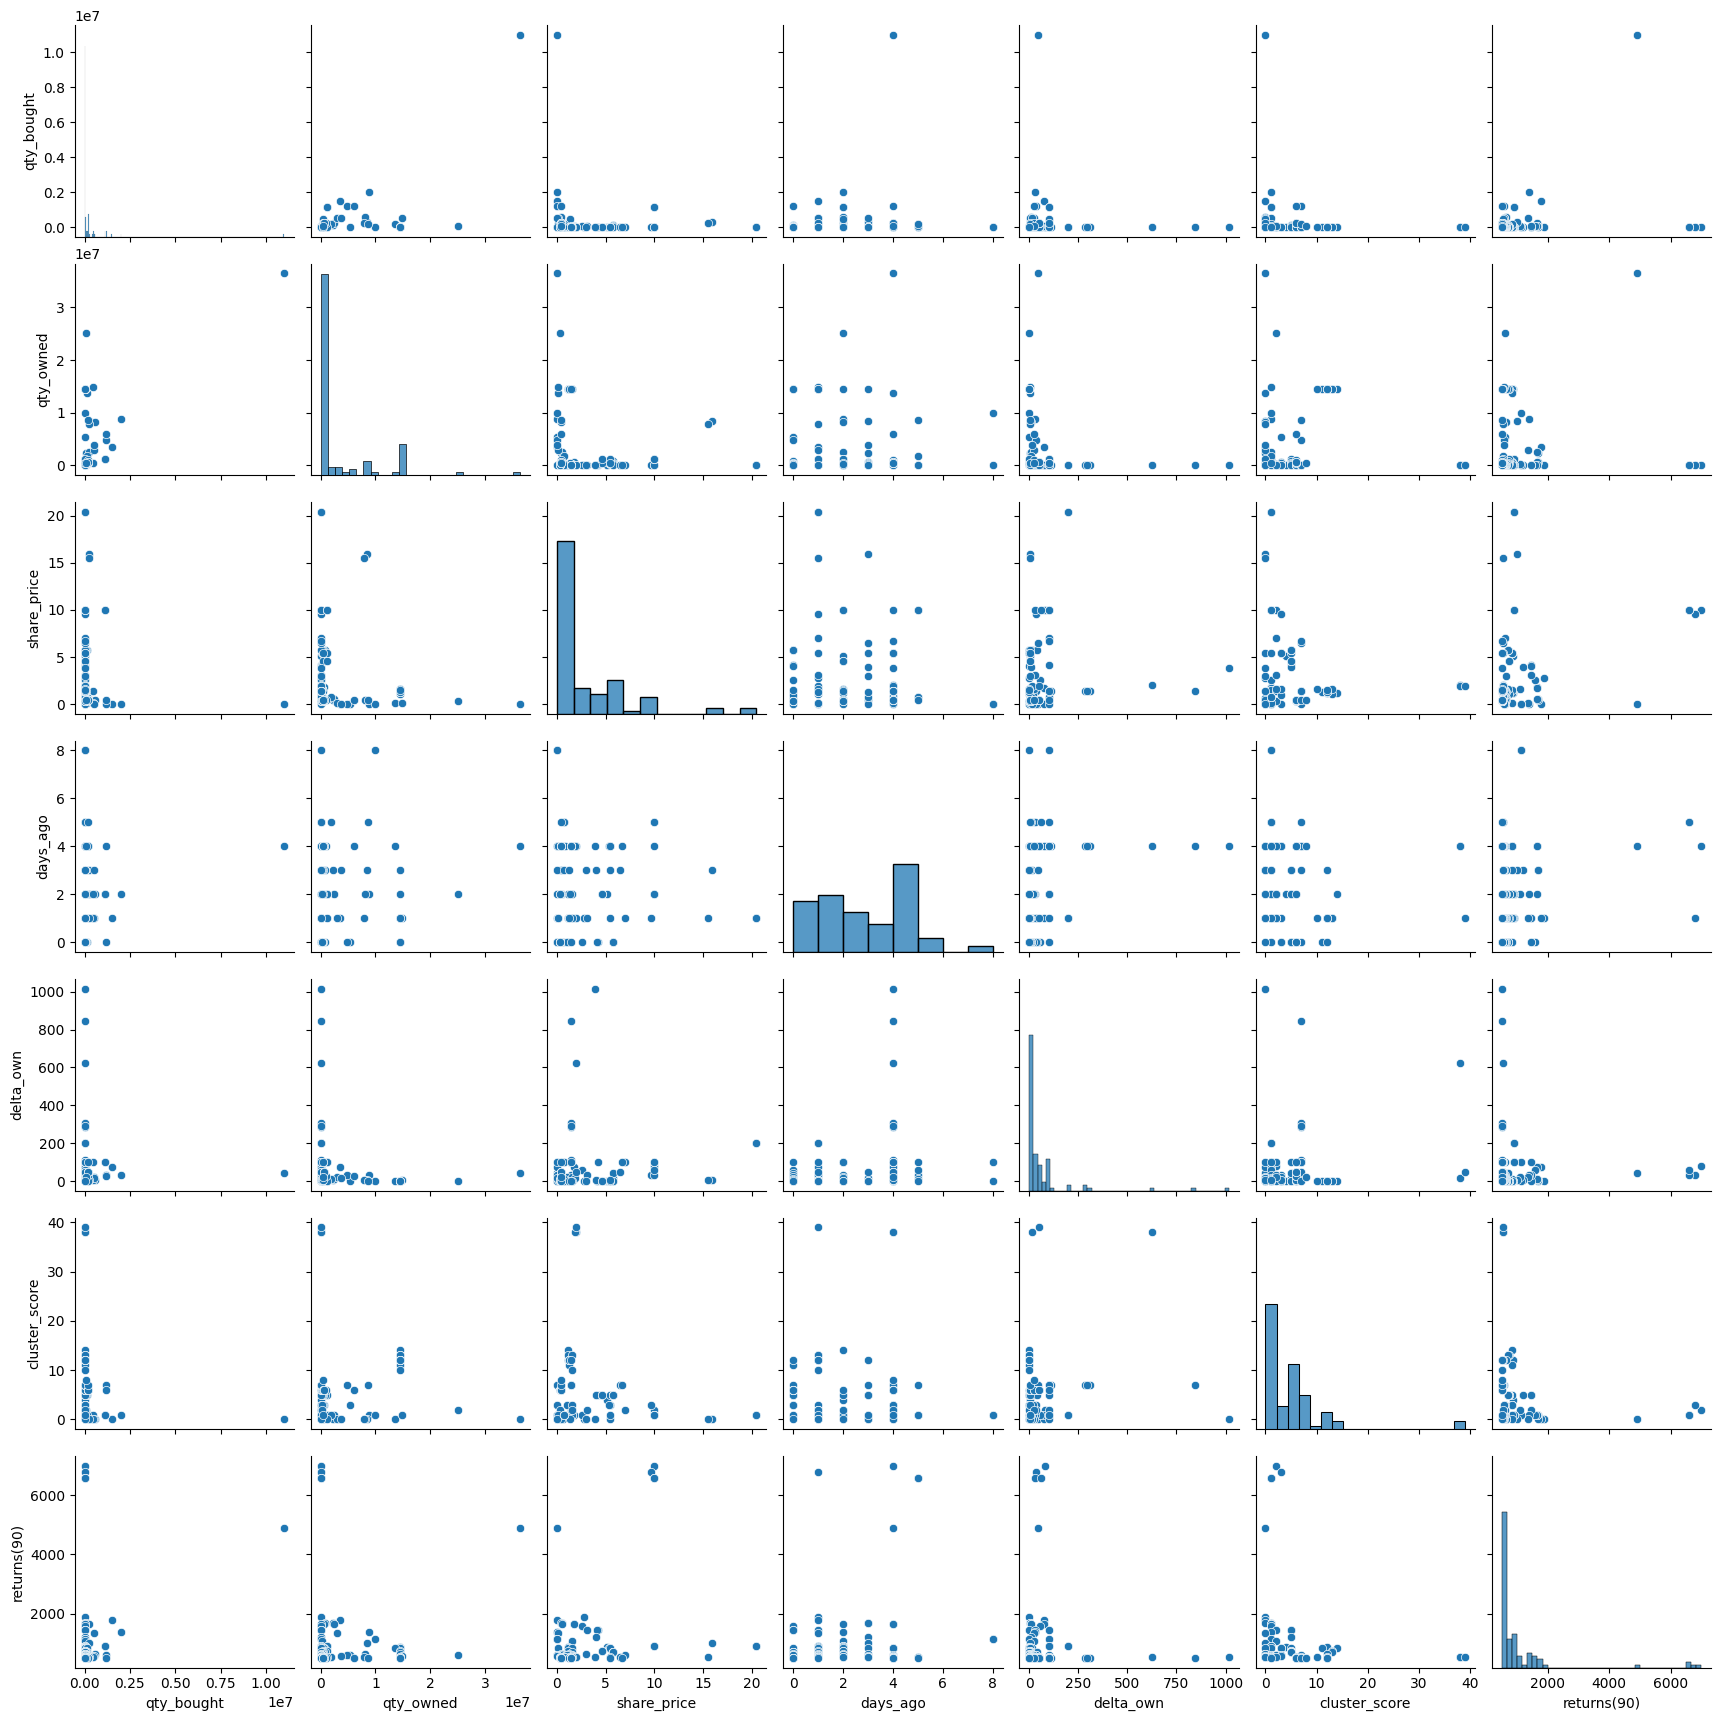

In [14]:
sns.pairplot(top100)

/var/folders/xj/xx8dqts16k97xqkkg6mrqkn40000gn/T/ipykernel_48160/1089941438.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  top100.corr(),


<AxesSubplot:>

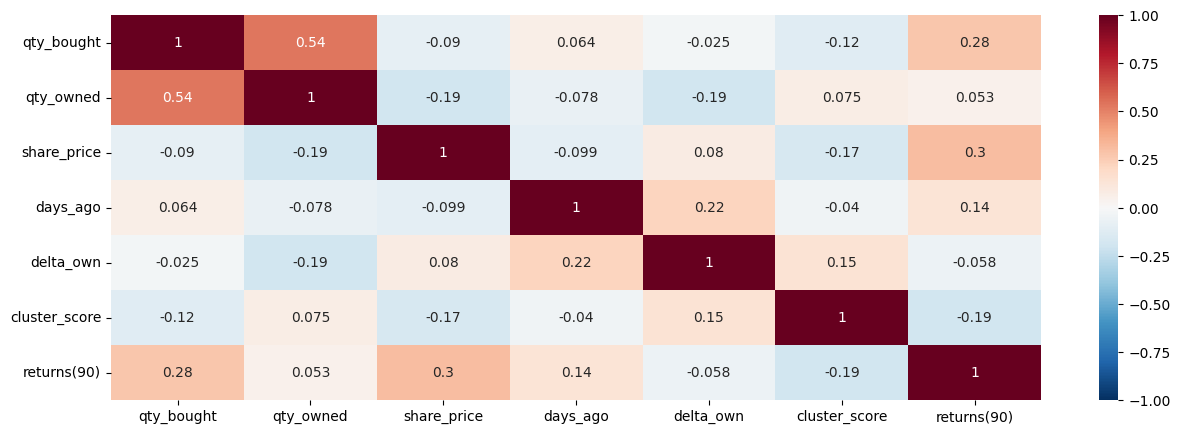

In [91]:
plt.figure(figsize=(15, 5))
sns.heatmap(
    top100.corr(),        
    cmap='RdBu_r', 
    annot=True, 
    vmin=-1, vmax=1
)

In [40]:
print(len(df[(df["qty_bought"] > 0) & (df["qty_bought"] < 1000)].loc[:, "returns(90)"]))
df[(df["qty_bought"] > 0) & (df["qty_bought"] < 1000)].loc[:, "returns(90)"].mean()

13227


3.820826510047136

In [39]:
print(len(df[(df["qty_bought"] > 1000) & (df["qty_bought"] < 10000)].loc[:, "returns(90)"]))
df[(df["qty_bought"] > 1000) & (df["qty_bought"] < 10000)].loc[:, "returns(90)"].mean()

11603


12.435827249072029

In [38]:
print(len(df[(df["qty_bought"] > 10_000) & (df["qty_bought"] < 100_000)].loc[:, "returns(90)"]))
df[(df["qty_bought"] > 10_000) & (df["qty_bought"] < 100_000)].loc[:, "returns(90)"].mean()

6252


13.948143061601808

In [47]:
print(len(df[df["qty_bought"] > 100_000].loc[:, "returns(90)"]))
df[(df["qty_bought"] > 100_000) & (df["qty_bought"] < 1_000_000)].loc[:, "returns(90)"].mean()

2678


12.096479526083083

In [36]:
print(len(df[df["qty_bought"] > 1_000_000].loc[:, "returns(90)"]))
df[df["qty_bought"] > 1_000_000].loc[:, "returns(90)"].mean()

572


28.729140133427194

In [52]:
def mean_w_bounds(column: str, bounds: list[int]) -> list[float]:
    assert column in df.columns

    means = []
    prev = -1
    for i, bound in enumerate(bounds):
        if i == 0:
            prev = bound
            continue

        lower = prev
        upper = bound
        if i == len(bounds) - 1:
            lower = bound
            upper = bound * 1000

        means.append(df[(df[column] > lower) & (df[column] < upper)].loc[:, "returns(90)"].mean())
        prev = bound

    return means

### FINDING
Perhaps the neural network failed from the lack of gneralization within the data set. For example, the exact qty_bought was input, but what if a value was passed in if the number of shares bought was within in a certain range. That would almost certainly be easier to find trends with than just the raw value. Could one-hot encode this or just create multiple input nodes for each of the categories. This should be done for more variables

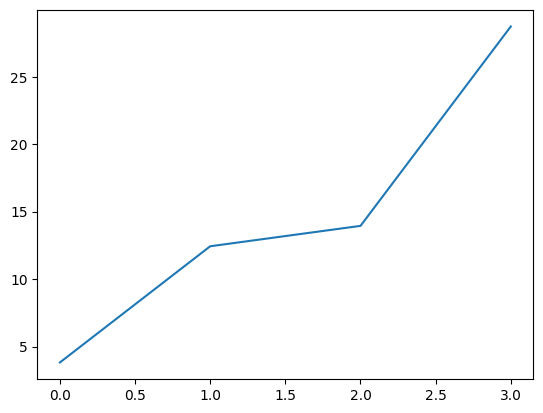

In [58]:
upper_bounds = [0, 1_000, 10_000, 100_000, 1_000_000]
plt.plot(mean_w_bounds("qty_bought", upper_bounds))
plt.show()